In [11]:
# General imports
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score 
from scipy.spatial import distance, distance_matrix
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

#### Import Data

In [12]:
#####################
# KDD Dataset
# First column is the BLOCK ID (class label), BLOCK IDs are integers running from 1 to 303 with 153 unique values (k)
# Second column is the ELEMENT ID (sample number), unique numbers, not ordered
# Third column is the class of the example. Homologous proteins = 1, non-homologous proteins = 0
data = pd.read_csv('bio_train.csv',skiprows=0).to_numpy(dtype='object')

#####################
# Toy Dataset
toy_data = np.genfromtxt('dataset1_noCluster7.csv', delimiter = ',')[1:]
toy_data_features = toy_data[:,:2]
toy_data_labels = toy_data[:,-1]

scaler = StandardScaler()
toy_data_features = scaler.fit_transform(toy_data_features)

#plt.scatter(toy_data_features[:,0], toy_data_features[:,1], c = toy_data_labels)
#plt.show()

#### Data Preprocessing

In [13]:
# Shuffle, split into labels/features and normalize data
def process_data(data):
    # Shuffle
    shuffle = np.random.permutation(len(data))
    data = data[shuffle]
    
    # Split
    block_ids = data[:,0]
    element_ids = data[:,1]
    homology = data[:,2]
    features = data[:,3:]
    
    # Normalize the features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    return block_ids, element_ids, features

In [14]:
# preprocess the data
block_ids, element_ids, features = process_data(data)
features = features.astype(np.float64) # only important if no normalization is done

### Task 1 - Lloyds Algorithm

In [15]:
def lloyds(data, k=153):
    # Number of samples and features of the dataset
    
    n_samples, n_features = np.shape(data)
    
    # Pick k random points from data to be the initial cluster centers (eventually use kmeans+ here?)
    #rand_nums = np.random.randint(0,n_samples,k)
    #cluster_means = data[rand_nums]
    
    # pick the first k points as initial cluster means
    cluster_means = data[:k]
    
    
    #kmeans++
    #cluster_means = kmeans_plus_initialization(data, k)
    
    old_means = np.zeros([k, n_features])
    counter = 0
    
    while (old_means != cluster_means).any():
    
        counter += 1
        old_means = np.copy(cluster_means)
        
        # avoiding endless loop
        if counter == 1000:
            break
            
        # printing progress
        if counter % 20 == 0: 
            print("iteration: ",counter)

            
        # measure assingment runtime
        #start_assign = time.perf_counter()
        
        ############# Assign step
        
        distance_matrix = cdist(data,cluster_means, metric='sqeuclidean')
        cluster_labels = np.argmin(distance_matrix, axis=1)
        
        ############# Update step
        for j in range(k):
            
            idcs = np.where(cluster_labels == j)[0]
            cluster_size = len(idcs)
            
            if cluster_size > 0:
                cluster_sum = np.sum(data[idcs], axis=0)
                cluster_means[j] = cluster_sum/cluster_size
            
            
        #end_update = time.perf_counter()
        
        #print('Assign step runtime: '+str(start_update - start_assign))
        #print('Update step runtime: '+str(end_update - start_update))
        
    print('KMeans converged in '+str(counter)+' iterations.')
    return cluster_labels, cluster_means


def kmeans_plus_initialization(data, k):
    no_samples = len(data)
    
    cluster_means = np.zeros((k,len(data[0])))
    cluster_means[0] = data[np.random.randint(0,no_samples)]
    
    for i in range(1,k):
        distances = cdist(data,cluster_means, metric='sqeuclidean')
        idx = np.argmax(np.min(distances, axis = 1))
        cluster_means[i] = data[idx]

    return cluster_means

In [6]:
# clustering the KDD Dataset
labels, centers = lloyds(features)

iteration:  20
iteration:  40
iteration:  60
iteration:  80
iteration:  100
iteration:  120
iteration:  140
iteration:  160
iteration:  180
iteration:  200
iteration:  220
iteration:  240
iteration:  260
iteration:  280
iteration:  300
iteration:  320
iteration:  340
iteration:  360
iteration:  380
iteration:  400
iteration:  420
iteration:  440
iteration:  460
iteration:  480
iteration:  500
iteration:  520
KMeans converged in 538 iterations.


In [8]:
NMI_score = normalized_mutual_info_score(block_ids, labels)
print(NMI_score)

0.18733534198596352


KMeans converged in 16 iterations.
0.8362575747555595


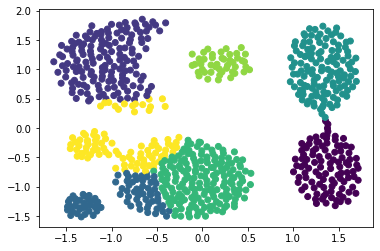

In [16]:
# run algorithm with the toy dataset
toy_labels, toy_centers = lloyds(toy_data_features, k=7)

NMI_score = normalized_mutual_info_score(toy_data_labels, toy_labels)
print(NMI_score)

plt.scatter(toy_data_features[:,0], toy_data_features[:,1], c = toy_labels)
plt.show()

### Task 2 - LSH + Kmeans

In [21]:
# this function defines a hash function according to the notes on LSH + Kmeans and assigns 
# the samples to the buckets.
# There is still a mistake in this function

def hash_simple(data, no_buckets):
    
    no_samples = len(data)
    
    hash_values = np.zeros(no_samples)
    
    vector_p = np.random.normal(loc=0.0, scale=1.0, size=len(data[0]))
    
    for i in range(n):
        hash_values[i] = data[i].dot(vector_p)
        
    min_val = np.min(hash_values)
    max_val = np.max(hash_values)
    
    bucket_size = (max_val-min_val) / (no_buckets-1)
    
    return np.floor(hash_values/bucket_size)

In [21]:
# This class defines a given number of hash functions. 
# The calculate_hash_values function can be used to calclueate the hash values of any array with no_features as the second dimension

# not finished, just playing around

class hash_functions:
    def __init__(self, no_functions, w, no_features):
        self.w = w #scalar
        self.b = np.zeros(no_functions) # vector
        self.a = np.random.normal(loc=0.0, scale=1.0, size=(no_functions, no_features)) # matrix

    def calculate_hash_values(self,data):
        
        temp_hash_values = (np.dot(data, self.a.T) + self.b) / self.w
        #np.max(temp_hash_values)
        
        return hash_values

In [22]:

# define hash functions
no_features = len(features[0])
w=3
hash_funcs = hash_functions(16, w, no_features)

#calculate the 16 hash values from all features
hash_values = hash_funcs.calculate_hash_values(features)

#print(hash_values)
"""
# pick the first k points as initial cluster means
cluster_means = data[:k]
old_means = np.zeros([k, n_features])
counter = 0

while (old_means != cluster_means).any():
    
    counter += 1
    old_means = np.copy(cluster_means)
    
    # calculate hash values of the cluster centers
    cluster_means_hashes = hash_funcs.calculate_hash_values(cluster_means)
    
    # link the hash values with AND and OR to form the final buckets
    
""" 
    
    